In [53]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import hvplot.pandas

In [54]:
from os import listdir
from os.path import isfile

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
dir = "../Resources/"

In [57]:
# Read all the files from the resources and put them in a list
all_files = [x for x in listdir(dir) if (".xlsx" in x or ".csv" in x)]
all_files

['corn.xlsx',
 'feeder_cattle.xlsx',
 'live_cattle.xlsx',
 'soybean_meal.xlsx',
 'lean_hogs.xlsx',
 'soybeans.xlsx']

In [58]:
all_df = pd.DataFrame()
for x in all_files:
    a = x.replace(".xlsx", "")
    df = pd.read_excel(dir+x)
    df["name"] = a
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()
    df = df.dropna()
    df = df[df['Volume'] != 0.0]
    df.drop(['Volume'], axis=1, inplace=True)
    if a == "corn":
        corn = df
        all_df["corn"] = corn["Price"]
    elif a == "live_cattle":
        live_cattle = df
        all_df["live_cattle"] = live_cattle["Price"]
    elif a == "feeder_cattle":
        feeder_cattle = df
        all_df["feeder_cattle"] = feeder_cattle["Price"]
    elif a == "soybean_meal":
        soybean = df
        all_df["soybean"] = soybean["Price"]
    elif a == "lean_hogs":
        hog = df
        all_df["hog"] = hog["Price"]

In [59]:
all_df['hog_delta_5'] = all_df["hog"].shift(105)
all_df['corn_delta_5'] = all_df["corn"].shift(105)
all_df['soybean_delta_5'] = all_df["soybean"].shift(105)
all_df = all_df.dropna()
# Crush Margin = 2 x CME lean hog futures price (5 months
# from placement) – 0.5 x CME lean hog futures price (5
# months from placement) – 10 x CME corn futures price (at
# placement) – 0.075 x CME soybean meal futures price (at
# placement)
# GFM t= 2.05 * LH t - WP t-5-(10 * C t-5)-(0.075 * SM t-5)
all_df["GFM"] = (2.05*all_df["hog"]) - (all_df['hog_delta_5']*0.5) - (10 * all_df['corn_delta_5']) - (0.075 * all_df['soybean_delta_5'])
all_df = all_df.drop(columns=['feeder_cattle', 'live_cattle', 'hog_delta_5', 'corn_delta_5', 'soybean_delta_5'])
all_df.head(10)

,corn,soybean,hog,GFM
Date,,,,
2001-06-04,2.1500,151.9,52.075,43.60625
2001-06-05,2.1425,152.2,51.575,42.77375
2001-06-06,2.1725,154.1,51.425,42.60625
2001-06-07,2.1700,153.8,51.600,42.64500
2001-06-08,2.1550,155.7,52.675,45.30625
2001-06-11,2.1725,156.8,53.375,46.54625
2001-06-12,2.1575,158.6,53.525,46.59875
2001-06-13,2.1525,157.7,53.600,46.86250
2001-06-14,2.1350,156.9,52.925,46.18375


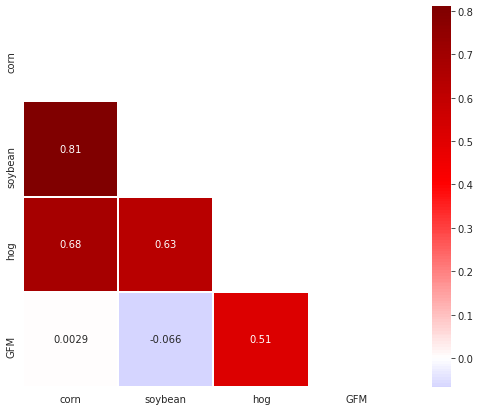

In [60]:
all_df = all_df.dropna()
corrM = all_df.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [61]:
all_df.hvplot.line(xlabel="Time", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [62]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [63]:
window_size = 10

feature_column = 0
# feature_column = 3
target_column = 2
X, y = window_data(all_df, window_size, feature_column, target_column)

In [64]:
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [65]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [66]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import metrics
# from tensorflow.keras import layers
# from tensorflow.keras import activations

In [68]:
model = Sequential()
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units = number_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1))
         )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(
    units = number_units,
    return_sequences = True,
        ))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(
    units = number_units,
    return_sequences = False,
        ))
model.add(Dropout(dropout_fraction))

model.add(Dense(1))
# model.add(Dense(12, input_dim=8, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.add(Activation('linear'))
# model.add(Activation('softmax')) 

In [69]:
model.compile(optimizer="adam", loss="mean_squared_error")
# model.compile(loss="mean_squared_error", optimizer = 'rmsprop', metrics=['accuracy'])
# model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mean_squared_error', 'accuracy'])

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 30)            3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [71]:
epochs = 100
batch_size = 64
model.fit(X_train, y_train, epochs=epochs, shuffle=True, batch_size=batch_size, verbose=1, validation_data=(X_train, y_train))

Epoch 1/100
50/50 [==============================] - 9s 51ms/step - loss: 0.0649 - val_loss: 0.0201
Epoch 2/100
50/50 [==============================] - 1s 20ms/step - loss: 0.0231 - val_loss: 0.0188
Epoch 3/100
50/50 [==============================] - 1s 19ms/step - loss: 0.0218 - val_loss: 0.0188
Epoch 4/100
50/50 [==============================] - 1s 19ms/step - loss: 0.0220 - val_loss: 0.0185
Epoch 5/100
50/50 [==============================] - 1s 20ms/step - loss: 0.0209 - val_loss: 0.0186
Epoch 6/100
50/50 [==============================] - 1s 23ms/step - loss: 0.0206 - val_loss: 0.0183
Epoch 7/100
50/50 [==============================] - 1s 23ms/step - loss: 0.0200 - val_loss: 0.0177
Epoch 8/100
50/50 [==============================] - 1s 22ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 9/100
50/50 [==============================] - 1s 22ms/step - loss: 0.0194 - val_loss: 0.0179
Epoch 10/100
50/50 [==============================] - 1s 20ms/step - loss: 0.0199 - val_loss: 0.0174

In [72]:
model.evaluate(X_test, y_test, verbose=0)

0.01195596531033516

In [73]:
predicted = model.predict(X_test)

In [74]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [75]:
metric = metrics.Accuracy()
metric.update_state(real_prices,predicted_prices)
metric.result().numpy()

0.0

In [76]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_prices, predicted_prices))

60.48243520487422


In [77]:
hogs = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
} ,index = all_df.index[-len(real_prices): ]) 
hogs.head()

,Real,Predicted
Date,,
2016-03-03,63.600,66.945633
2016-03-04,63.425,66.779594
2016-03-07,63.675,66.626595
2016-03-08,63.800,66.433029
2016-03-09,63.950,66.133171


In [78]:
hogs.hvplot.line(xlabel="Date", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)